# GTFS Routes

## Create a geopandas geodataframe from a GTFS feed

Here is a url for a GTFS data feed. Let's turn it into a flexible geodataframe!

In [21]:
url = 'http://web.mta.info/developers/data/nyct/bus/google_transit_brooklyn.zip'

We first have to import some modules from the [Python standard library](https://docs.python.org/3/library/)

We also have to import some third party modules.

Add the *conda-forge* channel to your base channel by running:

`conda config --add channels conda-forge`

You can then create an environment with these dependencies by running: 

`conda create --name geo_env --file package-list.txt`

In [22]:
import requests
from zipfile import ZipFile
from io import StringIO, BytesIO

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import geometry

Define a function for converting gtfs zipfiles into pandas dataframes. The dataframes are stored in a python dictionary.

In [23]:
def gtfsZipToDataframes(zip):
    # create a dictionary to store the dataframes
    dataframes = {}

    # check if the zipfile has the required files
    # stop_times.txt is also required for a GTFS feed, but not for this exercise
    required_files = ['agency.txt', 'stops.txt', 'routes.txt', 'trips.txt', 'shapes.txt']

    has_required_files = [req_file in (file.filename for file in zip.filelist) for req_file in required_files]

    if all(has_required_files):
        # also check if there are any files not part of the gtfs standard and alert the user
        standard_files = required_files + [
            'stop_times.txt', 'calendar.txt', 'calendar_dates.txt', 'fare_attributes.txt',
            'fare_rules.txt', 'frequencies.txt', 'transfers.txt', 'pathways.txt', 
            'levels.txt', 'translations.txt', 'feed_info.txt', 'attributions.txt'
        ]

        # for each file in the list
        for file in zip.filelist:
            file_name = file.filename
            # check that it is one of the standard files
            if any(standard_file_name == file_name for standard_file_name in standard_files):
                # open the file, read the data into a pandas dataframe, and add that to the dictionary
                with zip.open(file_name) as f:
                    bytes = f.read()
                    s = str(bytes, 'utf-8')
                    data = StringIO(s)
                    df = pd.read_csv(data, low_memory=False)
                    name = file_name.split('.txt')[0]
                    dataframes[name] = df
            else:
                print('%s is not part of the gtfs specification!' % file_name)
    else:
        missing_files = [required_files[i] for i, has_file in enumerate(has_required_files) if not has_file]
        raise Exception('GTFS feed does not have the required file(s): %s' % ' '.join(missing_files))

    return dataframes

Run the function and list the resulting dataframes. The number of dataframes will vary between different gtfs sources.

*You can also work with a local copy of the data for improved performance*

In [24]:
# zip = zipfile.ZipFile('data/nyc_subways.zip')
r = requests.get(url)
zip = ZipFile(BytesIO(r.content))
gtfs_dataframes = gtfsZipToDataframes(zip)
list(gtfs_dataframes)

['agency',
 'calendar',
 'calendar_dates',
 'routes',
 'shapes',
 'stops',
 'stop_times',
 'trips']

Let's take a look at the agency dataframe

In [25]:
agency = gtfs_dataframes['agency']
agency.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234


Here's the routes dataframe

In [26]:
routes = gtfs_dataframes['routes']
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color
0,B1,MTA NYCT,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF
1,B11,MTA NYCT,B11,Sunset Park - Midwood,via 49th & 50th St / Avenue J,3,006CB7,FFFFFF
2,B12,MTA NYCT,B12,Lefferts Gardens - East New York,via Clarkson Av / Empire Blvd / East New York Av,3,6CBE45,FFFFFF
3,B13,MTA NYCT,B13,Spring Creek - Wyckoff Hospital,via Crescent St / Jamaica Av / Wyckoff Av,3,FAA61A,FFFFFF
4,B14,MTA NYCT,B14,Spring Creek - Crown Heights,via Sutter Av / Pitkin Av,3,00AEEF,FFFFFF


We can join the agency and routes dataframes on the agency_id column

In [27]:
agency_routes = agency.join(
    routes.set_index('agency_id'),
    on='agency_id'
)
agency_routes.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,route_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B11,B11,Sunset Park - Midwood,via 49th & 50th St / Avenue J,3,006CB7,FFFFFF
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B12,B12,Lefferts Gardens - East New York,via Clarkson Av / Empire Blvd / East New York Av,3,6CBE45,FFFFFF
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B13,B13,Spring Creek - Wyckoff Hospital,via Crescent St / Jamaica Av / Wyckoff Av,3,FAA61A,FFFFFF
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B14,B14,Spring Creek - Crown Heights,via Sutter Av / Pitkin Av,3,00AEEF,FFFFFF


Here's a look at the trips datframe

In [28]:
trips = gtfs_dataframes['trips']
trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,B82+,EN_C1-Weekday,EN_C1-Weekday-028500_SBS82_901,SELECT BUS BENSNHRST BAY 38 via FLATLNDS,1,SBS821511
1,B82+,EN_C1-Weekday,EN_C1-Weekday-034800_SBS82_901,SELECT BUS SPRING CRK SEAVIEW via KINGS,0,SBS821510
2,B82+,EN_C1-Weekday,EN_C1-Weekday-040300_SBS82_901,SELECT BUS BENSNHRST BAY 38 via FLATLNDS,1,SBS821511
3,B82+,EN_C1-Weekday,EN_C1-Weekday-048000_SBS82_901,SELECT BUS SPRING CRK SEAVIEW via KINGS,0,SBS821510
4,B82+,EN_C1-Weekday,EN_C1-Weekday-029900_SBS82_902,SELECT BUS BENSNHRST BAY 38 via FLATLNDS,1,SBS821511


We can join the trips and routes dataframes on the route_id

In [29]:
routes_trips = agency_routes.join(
    trips.set_index('route_id'),
    on='route_id'
)
routes_trips.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,route_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,service_id,trip_id,trip_headsign,direction_id,shape_id
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-009800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-013800_B1_2,MANHATTAN BEACH KINGSBORO CC,1.0,B10016
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-017800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-021800_B1_2,MANHATTAN BEACH KINGSBORO CC,1.0,B10016
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-025800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016


This is the shapes dataframe. It contains the spatial data for the trips in the GTFS feed.

In [30]:
shapes = gtfs_dataframes['shapes']
shapes.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,B10009,40.576744,-73.965485,10001
1,B10009,40.576832,-73.965089,10002
2,B10009,40.577022,-73.964189,10003
3,B10009,40.577101,-73.963815,10004
4,B10009,40.577101,-73.963815,20001


We can join the shapes and trips on the shape_id column. Let's also drop a bunch of columns that no longer need.

In [31]:
shapes_trips = shapes.join(
    routes_trips.set_index('shape_id'),
    on='shape_id'
)

shapes_trips.drop(
    [
#         'service_id',
#         'trip_id',
#         'trip_headsign',
#         'direction_id',
        'block_id',
        'shape_pt_sequence',
        'shape_dist_traveled'
    ], 
    axis=1,
    errors='ignore',
    inplace=True
)
shapes_trips.head()

,shape_id,shape_pt_lat,shape_pt_lon,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,route_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,service_id,trip_id,trip_headsign,direction_id
0,B10009,40.576744,-73.965485,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday-SDon,UP_C1-Weekday-SDon-046400_B1_2,MANHATTAN BEACH KINGSBORO CC,1.0
0,B10009,40.576744,-73.965485,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday-SDon,UP_C1-Weekday-SDon-054700_B1_12,MANHATTAN BEACH KINGSBORO CC,1.0
0,B10009,40.576744,-73.965485,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday-SDon,UP_C1-Weekday-SDon-049100_B1_2,MANHATTAN BEACH KINGSBORO CC,1.0
0,B10009,40.576744,-73.965485,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday-SDon,UP_C1-Weekday-SDon-051300_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0
0,B10009,40.576744,-73.965485,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday-SDon,UP_C1-Weekday-SDon-052300_B1_2,MANHATTAN BEACH KINGSBORO CC,1.0


Let's list the unique route ids

In [32]:
list(routes.route_id.unique())

['B1',
 'B11',
 'B12',
 'B13',
 'B14',
 'B15',
 'B16',
 'B17',
 'B2',
 'B20',
 'B24',
 'B25',
 'B26',
 'B3',
 'B31',
 'B32',
 'B35',
 'B36',
 'B37',
 'B38',
 'B39',
 'B4',
 'B41',
 'B42',
 'B43',
 'B44',
 'B44+',
 'B45',
 'B46',
 'B46+',
 'B47',
 'B48',
 'B49',
 'B52',
 'B54',
 'B57',
 'B6',
 'B60',
 'B61',
 'B62',
 'B63',
 'B64',
 'B65',
 'B67',
 'B68',
 'B69',
 'B7',
 'B70',
 'B74',
 'B8',
 'B82',
 'B82+',
 'B83',
 'B84',
 'B9',
 'B91',
 'B91A',
 'B92',
 'B98V',
 'B99',
 'BX3',
 'BX4',
 'BX4A',
 'BX5',
 'BX6',
 'BX6+',
 'BX7',
 'BX8',
 'BX9',
 'BX1',
 'BX10',
 'BX11',
 'BX12',
 'BX12+',
 'BX13',
 'BX15',
 'BX16',
 'BX17',
 'BX18',
 'BX19',
 'BX2',
 'BX20',
 'BX21',
 'BX22',
 'BX24',
 'BX25',
 'BX26',
 'BX27',
 'BX28',
 'BX29',
 'BX30',
 'BX31',
 'BX32',
 'BX33',
 'BX34',
 'BX35',
 'BX36',
 'BX38',
 'BX39',
 'BX40',
 'BX41',
 'BX41+',
 'BX42',
 'BX46',
 'BX99',
 'EBUS',
 'SHGRD',
 'SHNRD',
 'SIR5',
 'SHUT5',
 'GHAS',
 'MVAS',
 'MQAS',
 'OFAS',
 'OHAS',
 'ENAS',
 'FBAS',
 'GAAS',
 'JGA

Now for the fun part... We're going to transform this data into a geodataframe. Additional notes describing each step are provided in the code comments.

In [40]:
# create a list to store the shapes for each route
route_list = []

# for each unique route_id
# for route_id in routes.route_id.unique():
for route_id in ['B35']:
    
    # get the route shapes
    route_shapes = shapes_trips.loc[shapes_trips.route_id == route_id]
    
    # check if there are shapes
    if route_shapes.size > 0:
        
        # get the points for each shape
        route_shapes = route_shapes.drop_duplicates(
            subset=['shape_id', 'shape_pt_lat', 'shape_pt_lon'],
            keep='first'
        ).reset_index(drop=True)

        # add a shapely geometry column
        route_shapes['geometry'] = route_shapes.apply(
            lambda row: geometry.Point(row.shape_pt_lon, row.shape_pt_lat),
            axis=1
        )

        # create a new dataframe with one row for each route shape
        unique_route_shapes = route_shapes.drop_duplicates(
            subset=['shape_id'],
            keep='first'
        ).drop(
            [
                'shape_pt_lat',
                'shape_pt_lon'
            ], 
            axis=1
        ).reset_index(drop=True)

        # create a linestring for each shape from its points
#         unique_route_shapes['geometry'] = unique_route_shapes.apply(
#             lambda row: geometry.LineString(
#                 route_shapes.loc[route_shapes.shape_id == row.shape_id].geometry.to_list()
#             ),
#             axis=1
#         )
        unique_route_shapes['geometry'] = unique_route_shapes.apply(
            lambda row: geometry.MultiPoint(
                route_shapes.loc[route_shapes.shape_id == row.shape_id].geometry.to_list()
            ),
            axis=1
        )

        # append the shapes to the route list
        route_list.append(unique_route_shapes)
    
    else:
        
        print('No spatial data for route %s' % route_id)

# create a geodataframe from the route list
network_routes = gpd.GeoDataFrame(pd.concat(route_list)).reset_index(drop=True)
network_routes.set_crs(4326, inplace=True) # set the spatial reference
network_routes.to_file('data/b35.geojson', driver="GeoJSON")
# network_routes.to_crs(epsg=3857, inplace=True) # project the coordinates
network_routes.head()

,shape_id,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,route_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,service_id,trip_id,trip_headsign,direction_id,geometry
0,B350004,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B35,B35,Brownsville - Sunset Park,via Church Av / 39th St,3,EE352E,FFFFFF,JG_C1-Weekday,JG_C1-Weekday-039400_B35_518,BROWNSVILLE MOTHER GASTON BL via CHURCH,0.0,"MULTIPOINT (-73.97963 40.64271, -73.97945 40.6..."
1,B350005,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B35,B35,Brownsville - Sunset Park,via Church Av / 39th St,3,EE352E,FFFFFF,JG_C1-Weekday,JG_C1-Weekday-003000_B35_501,BROWNSVILLE MOTHER GASTON BL via CHURCH,0.0,"MULTIPOINT (-74.01200 40.65618, -74.01045 40.6..."
2,B350006,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B35,B35,Brownsville - Sunset Park,via Church Av / 39th St,3,EE352E,FFFFFF,JG_C1-Weekday,JG_C1-Weekday-037500_B35_501,LIMITED BROWNSVILLE M GASTON via CHURCH,0.0,"MULTIPOINT (-74.01200 40.65618, -74.01045 40.6..."
3,B350204,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B35,B35,Brownsville - Sunset Park,via Church Av / 39th St,3,EE352E,FFFFFF,JG_C1-Weekday,JG_C1-Weekday-118000_B35_555,LIMITED SUNSET PARK 1 AV via CHURCH AV,1.0,"MULTIPOINT (-73.90498 40.65661, -73.90545 40.6..."
4,B350209,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B35,B35,Brownsville - Sunset Park,via Church Av / 39th St,3,EE352E,FFFFFF,JG_C1-Weekday,JG_C1-Weekday-118600_B35_558,McDONALD AV via CHURCH AV,1.0,"MULTIPOINT (-73.90498 40.65661, -73.90625 40.6..."


In [34]:
# def linestring_to_points(feature,line):
#     return {feature:line.coords}

# network_routes['points'] = network_routes.apply(lambda l: linestring_to_points(l['shape_id'],l['geometry']),axis=1)
# network_routes.head()

Check if there is a route color and set a default, if none.

In [35]:
default_color = '000000'
if 'route_color' in network_routes.columns:
    network_routes.route_color.fillna(default_color, inplace=True)
else:
    network_routes.route_color = default_color

Now we can plot the geodataframe

C:\Users\codonnell\Anaconda3\envs\geo_env\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 32 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


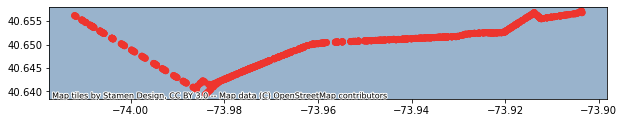

In [36]:
ax = network_routes.plot(color='#' + network_routes.route_color, figsize=(10, 10))
ctx.add_basemap(ax)
plt.show()

Contextily provides a number of basemap sources

In [37]:
list(ctx.providers.keys())

['OpenStreetMap',
 'OpenSeaMap',
 'OpenPtMap',
 'OpenTopoMap',
 'OpenRailwayMap',
 'OpenFireMap',
 'SafeCast',
 'Thunderforest',
 'OpenMapSurfer',
 'Hydda',
 'MapBox',
 'Stamen',
 'Esri',
 'OpenWeatherMap',
 'HERE',
 'FreeMapSK',
 'MtbMap',
 'CartoDB',
 'HikeBike',
 'BasemapAT',
 'nlmaps',
 'NASAGIBS',
 'NLS',
 'JusticeMap',
 'Wikimedia',
 'GeoportailFrance',
 'OneMapSG']

Let's take a look at CartoDB

In [38]:
list(ctx.providers.CartoDB.keys())

['Positron',
 'PositronNoLabels',
 'PositronOnlyLabels',
 'DarkMatter',
 'DarkMatterNoLabels',
 'DarkMatterOnlyLabels',
 'Voyager',
 'VoyagerNoLabels',
 'VoyagerOnlyLabels',
 'VoyagerLabelsUnder']

The Positron tileset gives us a nice light background so we can easily see our routes.

C:\Users\codonnell\Anaconda3\envs\geo_env\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 32 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


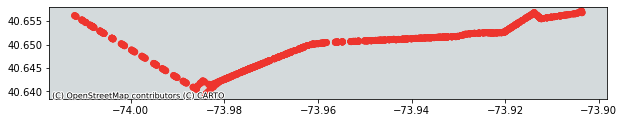

In [39]:
ax = network_routes.plot(color='#' + network_routes.route_color, figsize=(10, 10))
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()